In [40]:
import time
import math
from functools import partial
from typing import Optional, Tuple
import jax
import jax.numpy as jnp
import jax.random as jr 
import equinox as eqx
from jaxtyping import Key, Array
import optax
import matplotlib.pyplot as plt 
import torch
import torchvision
from tqdm import trange

In [41]:
class QConv(eqx.Module):
    num_spatial_dims: int 
    weight: Array
    bias: Optional[Array]
    in_channels: int 
    out_channels: int
    kernel_size: tuple[int, ...] 
    stride: tuple[int, ...] 
    padding: int 
    dilation: tuple[int, ...] 
    groups: int 
    use_bias: bool 
    padding_mode: str 
    # Q arrays
    e: Array
    b: Array

    def __init__(
        self,
        num_spatial_dims: int,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        padding: int = 0,
        groups: int = 1,
        use_bias: bool = True,
        padding_mode: str = "ZEROS",
        *,
        key: Key,
    ):
        # Conv stuff (many defaults...)
        kernel_size = (kernel_size,) * num_spatial_dims
        stride = (1,) * num_spatial_dims
        dilation = (1,) * num_spatial_dims
        padding = tuple((padding, padding) for _ in range(num_spatial_dims))

        wkey, bkey = jr.split(key, 2)
        # Initialisation limit
        grouped_in_channels = in_channels // groups
        lim = 1. / math.sqrt(grouped_in_channels * math.prod(kernel_size))

        # Weight
        wshape = (out_channels, grouped_in_channels) + kernel_size
        self.weight = jr.uniform(wkey, wshape, minval=-lim, maxval=lim)

        # Bias
        bshape = (out_channels,) + (1,) * num_spatial_dims
        self.bias = jr.uniform(bkey, bshape, minval=-lim, maxval=lim) if use_bias else None

        # Q arrays
        self.e = jnp.ones((out_channels,) + (1,) * (num_spatial_dims + 1)) * -8
        self.b = jnp.ones((out_channels,) + (1,) * (num_spatial_dims + 1)) * 2. # 2 bits per weight initially

        self.num_spatial_dims = num_spatial_dims
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.use_bias = use_bias
        self.padding_mode = padding_mode

    def __call__(self, x: Array, *, key: Optional[Key] = None) -> Array:
        b_positive = jnp.maximum(self.b, 0.1)
        qw = jnp.clip(
            2 ** -self.e * self.weight,
            min=-2 ** (b_positive - 1),
            max=2 ** (b_positive - 1) - 1
        )
        w = jax.lax.stop_gradient(qw.round() - qw) + qw

        x = jnp.expand_dims(x, axis=0)
        x = jax.lax.conv_general_dilated(
            lhs=x,
            rhs=2 ** self.e * w, 
            window_strides=self.stride,
            padding=self.padding, # Forcing "ZEROS" padding
            rhs_dilation=self.dilation,
            feature_group_count=self.groups,
        )
        x = jnp.squeeze(x, axis=0)

        if self.use_bias:
            x = x + self.bias
        return x

In [42]:
class Model(eqx.Module):
    conv1: QConv
    conv2: QConv
    pool1: eqx.nn.MaxPool2d
    conv3: QConv
    conv4: QConv
    pool2: eqx.nn.MaxPool2d
    out: eqx.nn.Linear

    def __init__(self, *, key):
        keys = jr.split(key, 5)
        conv_kwargs = dict(num_spatial_dims=2, use_bias=False) # Need to setup counting of bias array

        self.conv1 = QConv(
            in_channels=1, out_channels=32, kernel_size=5, **conv_kwargs, key=keys[0]
        )
        self.conv2 = QConv(
            in_channels=32, out_channels=32, kernel_size=5, **conv_kwargs, key=keys[1]
        )
        self.pool1 = eqx.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = QConv(
            in_channels=32, out_channels=64, kernel_size=3, **conv_kwargs, key=keys[2]
        )
        self.conv4 = QConv(
            in_channels=64, out_channels=64, kernel_size=3, **conv_kwargs, key=keys[3]
        )
        self.pool2 = eqx.nn.MaxPool2d(kernel_size=2, stride=2)

        self.out = eqx.nn.Linear(1024, 10, key=keys[4])

    def __call__(self, x: Array) -> Array:
        x = self.conv1(x)
        x = jax.nn.tanh(x)
        x = self.conv2(x)
        x = jax.nn.tanh(x)
        x = self.pool1(x)
        
        x = self.conv3(x)
        x = jax.nn.tanh(x)
        x = self.conv4(x)
        x = jax.nn.tanh(x)
        x = self.pool2(x)
        
        x = self.out(x.flatten())
        return x

In [43]:
def qbits_fn(model: eqx.Module, weight_count: bool = False) -> int:
    def _size_fn(x):
        weight_size = jnp.prod(jnp.asarray(x.weight.shape[1:]))
        if weight_count:
            return weight_size
        else:
            return weight_size * jnp.sum(jnp.maximum(x.b, 0.1)) 

    is_qconv = lambda x: isinstance(x, QConv)
    get_b_and_weight_sizes = lambda m: [
        _size_fn(x)
        for x in jax.tree_util.tree_leaves(m, is_leaf=is_qconv)
        if is_qconv(x)
    ]
    return sum(get_b_and_weight_sizes(model))


def cross_entropy_loss(logits: Array, labels: Array) -> Array:
    return optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()


def compute_metrics(logits: Array, labels: Array) -> dict:
    loss = cross_entropy_loss(logits, labels)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == labels)
    return {'loss': loss, 'accuracy': accuracy}


@eqx.filter_jit
def train_step(model, opt_state, x, y, weight_count):
    def loss_fn(model):
        logits = jax.vmap(model)(x) 
        loss = cross_entropy_loss(logits, y)
        Q = qbits_fn(model) / weight_count
        L = loss + 0.05 * Q # Q pre-factor balances accuracy and model size
        return L, logits

    grad_fn = eqx.filter_value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model)
    
    updates, opt_state = opt.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)

    metrics = compute_metrics(logits, y)
    metrics['Q'] = qbits_fn(model) / weight_count
    
    return model, opt_state, metrics


@eqx.filter_jit
def eval_step(model, x, y):
    logits = jax.vmap(model)(x)
    return compute_metrics(logits, y)


def convert(x: torch.Tensor, y: torch.Tensor) -> Tuple[Array, Array]:
    return jnp.asarray(x.numpy()), jnp.asarray(y.numpy())


In [44]:
key = jr.key(0)

model = Model(key=key)

# Initial number of weights (no biases) excluding Q arrays
# weight_count = qbits_fn(model, weight_count=False)
weight_count = sum(
    p.size for p in jax.tree_util.tree_leaves(eqx.filter(model, eqx.is_array))
)

print("n_params =", weight_count)
print(f"Initial model size: {qbits_fn(model) / 8:.1f} bytes")

n_params = 92330
Initial model size: 20424.0 bytes


In [45]:
num_epochs = 50
batch_size = 512
lr = 1e-3

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(32),
        torchvision.transforms.Normalize((0.5,), (0.5,))
    ]
)
train_ds = torchvision.datasets.MNIST(
    '~/MNIST', train=True, download=True, transform=transform
)
valid_ds = torchvision.datasets.MNIST(
    '~/MNIST', train=False, transform=transform
)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size)

In [46]:
opt = optax.adam(learning_rate=lr)
opt_state = opt.init(eqx.filter(model, eqx.is_array))

metric_keys = ["Q", "loss", "accuracy"]
all_metrics = []
bar = trange(num_epochs, colour="magenta")
for epoch in bar:
    
    # Train
    train_epoch_metrics = []
    for i, (x, y) in enumerate(train_loader):
        x, y = convert(x, y)

        # Loss and updates 
        model, opt_state, metrics = train_step(
            model, opt_state, x, y, weight_count
        )

        # Record
        train_epoch_metrics.append(metrics)
        model_bytes = metrics['Q'] * weight_count / 8
        bar.set_description(
            (
                f"loss: {metrics['loss']:6.2f} "  
                f"bytes: {model_bytes:.1f} "
                f"acc: {metrics['accuracy']:5.2f}"
            )
        )
    
    avg_train_metrics = {
        key: sum(m[key] for m in train_epoch_metrics) / len(train_epoch_metrics)
        for key in metric_keys
    }

    # Evaluate 
    valid_metrics = []
    for i, (x, y) in enumerate(valid_loader):
        x, y = convert(x, y)
        metrics = eval_step(model, x, y)
        valid_metrics.append(metrics)
    
    avg_valid_metrics = {
        key: sum(m[key] for m in valid_metrics) / len(valid_metrics)
        for key in metric_keys[1:]
    }
    
    all_metrics.extend(train_epoch_metrics)

loss:   1.53 bytes: 20876.5 acc:  0.56:   0%|          | 0/50 [00:40<?, ?it/s]

In [ ]:
print(f"Final model size: {qbits_fn(model) / 8:.1f} bytes.")

Final model size: 21360.5 bytes.


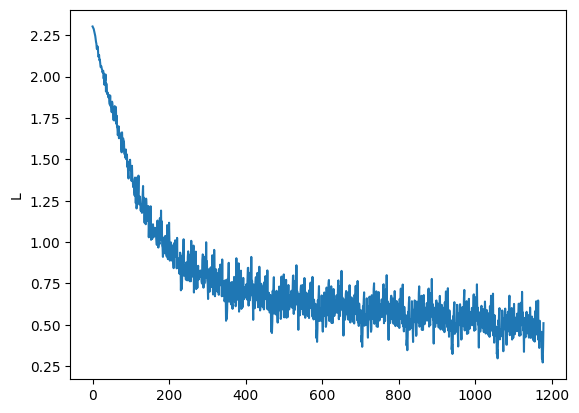

In [ ]:
L = [m["loss"] for m in all_metrics]

plt.figure()
plt.plot(L)
plt.ylabel("L")
plt.savefig("figs/loss.png")
plt.show()

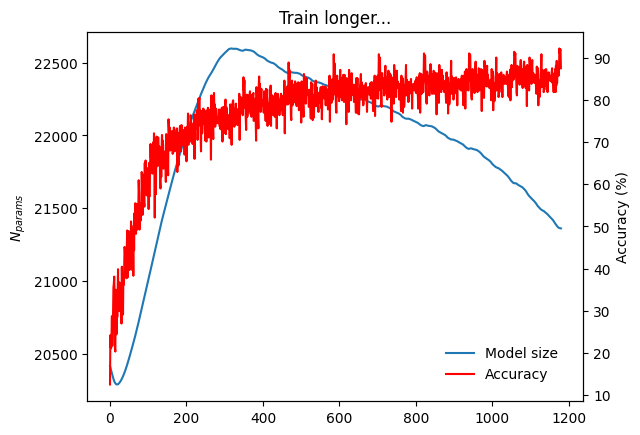

In [ ]:
q = [m["Q"] * weight_count / 8 for m in all_metrics]
accuracy = [100. * m["accuracy"] for m in all_metrics]

fig = plt.figure()
plt.title("Train longer...")
plt.plot(q, label="Model size")
plt.ylabel(r"$N_{params}$")
plt.twinx()
plt.plot(accuracy, color="red", label="Accuracy")
plt.ylabel("Accuracy (%)")
fig.legend(frameon=False, loc="upper right", bbox_to_anchor=(0.88, 0.25))
plt.savefig("figs/accuracy_and_model_size.png")
plt.show()